In [5]:
import numpy as np
np.set_printoptions(formatter={'float': '{: 0.5f}'.format}, suppress = True)

Z = np.array(
    [229.279549, 230.438029, 231.596509, 232.754989, 233.913469, 235.071949, 239.943090, 241.155750, 
     242.368410, 243.581070, 244.793729, 353.834155, 355.699874, 357.565593, 359.431312, 361.297031, 
     363.162750, 374.165002, 376.140791, 380.092371, 382.068161, 384.043951, 492.024129, 494.829550, 
     497.634972, 500.440393, 503.245814, 506.051235, 514.290602, 517.224547, 520.158493, 523.092438, 
     528.960329]
)

In [12]:
# Reads a BField file and returns a dictionary containing a set of vectors representing the field
def read_file(filename):
    B   = {}
    for z in Z:
        B[z] = [[], [], [], [], [], []]

    f = open(filename, "r")

    for line in f:
        list = line.replace("\n", "").split(' ')
        for i in range(len(list)):
            list[i] = float(list[i])
    
        for i in range(len(list)):
            B[list[2]][i].append(list[i])

    for z in B:
        for i in range(len(B[z])):
            B[z][i] = np.array(B[z][i])
    
    return B

In [7]:
# Gets the approximated magnetic field at a point using the nearest neighbour criteria
def get_b_nn(B, x0, y0, z0):
    if z0 in B:
        b  = B[z0]
        
        d_x = np.abs(b[0] - x0)
        d_y = np.abs(b[1] - y0)
        
        x_min = d_x.min()
        y_min = d_y.min()
        
        Xi = np.where(d_x == x_min)
        Yi = np.where(d_y == y_min)
        
        for xi in Xi[0]:
            for yi in Yi[0]:
                if xi == yi:
                    return (b[3][xi], b[4][xi], b[5][xi])
        return None
    else:
        return None

def get_b_li(B, x0, y0, z0):
    

In [21]:
B = read_file("B.txt")

<IPython.core.display.Javascript object>


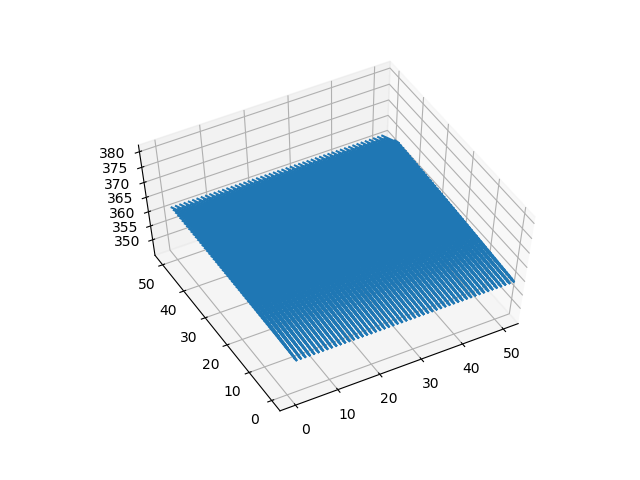

In [22]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook

z = 363.162750

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.quiver(B[z][0], B[z][1], B[z][2], B[z][3], B[z][4], B[z][5], length=5, normalize=True)

plt.show()